#### Import the real (Reddit) conversations and synthetic (GPT-4 generated) conversations and run the Team Communication Toolkit featurizer
##### Note: this step takes 10+ hours to run if you are creating vectors. For this demo, we directly use features that have already been generated by us.

In [1]:
from team_comm_tools import FeatureBuilder
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_1samp
from tqdm import tqdm
import pickle
import os

from feature_lists import *

plt.style.use('default')
plt.rcParams['figure.dpi'] = 600
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['figure.facecolor'] = 'white'
matplotlib.rcParams['grid.alpha'] = 0.0

[nltk_data] Downloading package wordnet to /Users/xehu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Load in data and subsample with respect to confounders

## Raw inputs

In [2]:
gpt_data = pd.read_csv('input-files/gpt_data.csv')

In [3]:
df_awry = pd.read_csv('input-files/conversations_gone_awry.csv')
df_winning = pd.read_csv('input-files/winning_conversations.csv')
# filter out "ORIGINAL_POST" from df_winning
df_winning = df_winning[df_winning['reply_to'] != 'ORIGINAL_POST']
df_reddit_orig = pd.concat([df_winning, df_awry])

## Old TCT Outputs

In [4]:
# data = pd.read_csv('input-files/gpt_data.csv')
# data['message'] = data['message'].astype(str)

# feature_builder = FeatureBuilder(
# input_df =  data,
# custom_features = [
# "(BERT) Mimicry",
# "Moving Mimicry",
# "Forward Flow",
# "Discursive Diversity"],
# speaker_id_col = "speaker_nickname",
# message_col = "message",
# timestamp_col = "timestamp",
# vector_directory = "./vector_data/",
# output_file_base = "gpt_output"
# )

# feature_builder.featurize()

# Chat level features
reddit_chat_level_data = pd.read_csv('output/chat/combined_reddit_output_chat_level.csv')
gpt_chat_level_data = pd.read_csv('output/chat/gpt_output_chat_level.csv')

# Conversation level features
reddit_conv_level_data = pd.read_csv('output/conv/combined_reddit_output_conv_level.csv')
gpt_conv_level_data = pd.read_csv('output/conv/gpt_output_conv_level.csv')

compute_weights(reddit_chat_level_data)
compute_weights(gpt_chat_level_data)

reddit_combined = aggregate_chat_level_features(reddit_chat_level_data,reddit_conv_level_data)
gpt_combined = aggregate_chat_level_features(gpt_chat_level_data,gpt_conv_level_data)

## Distribution Checks

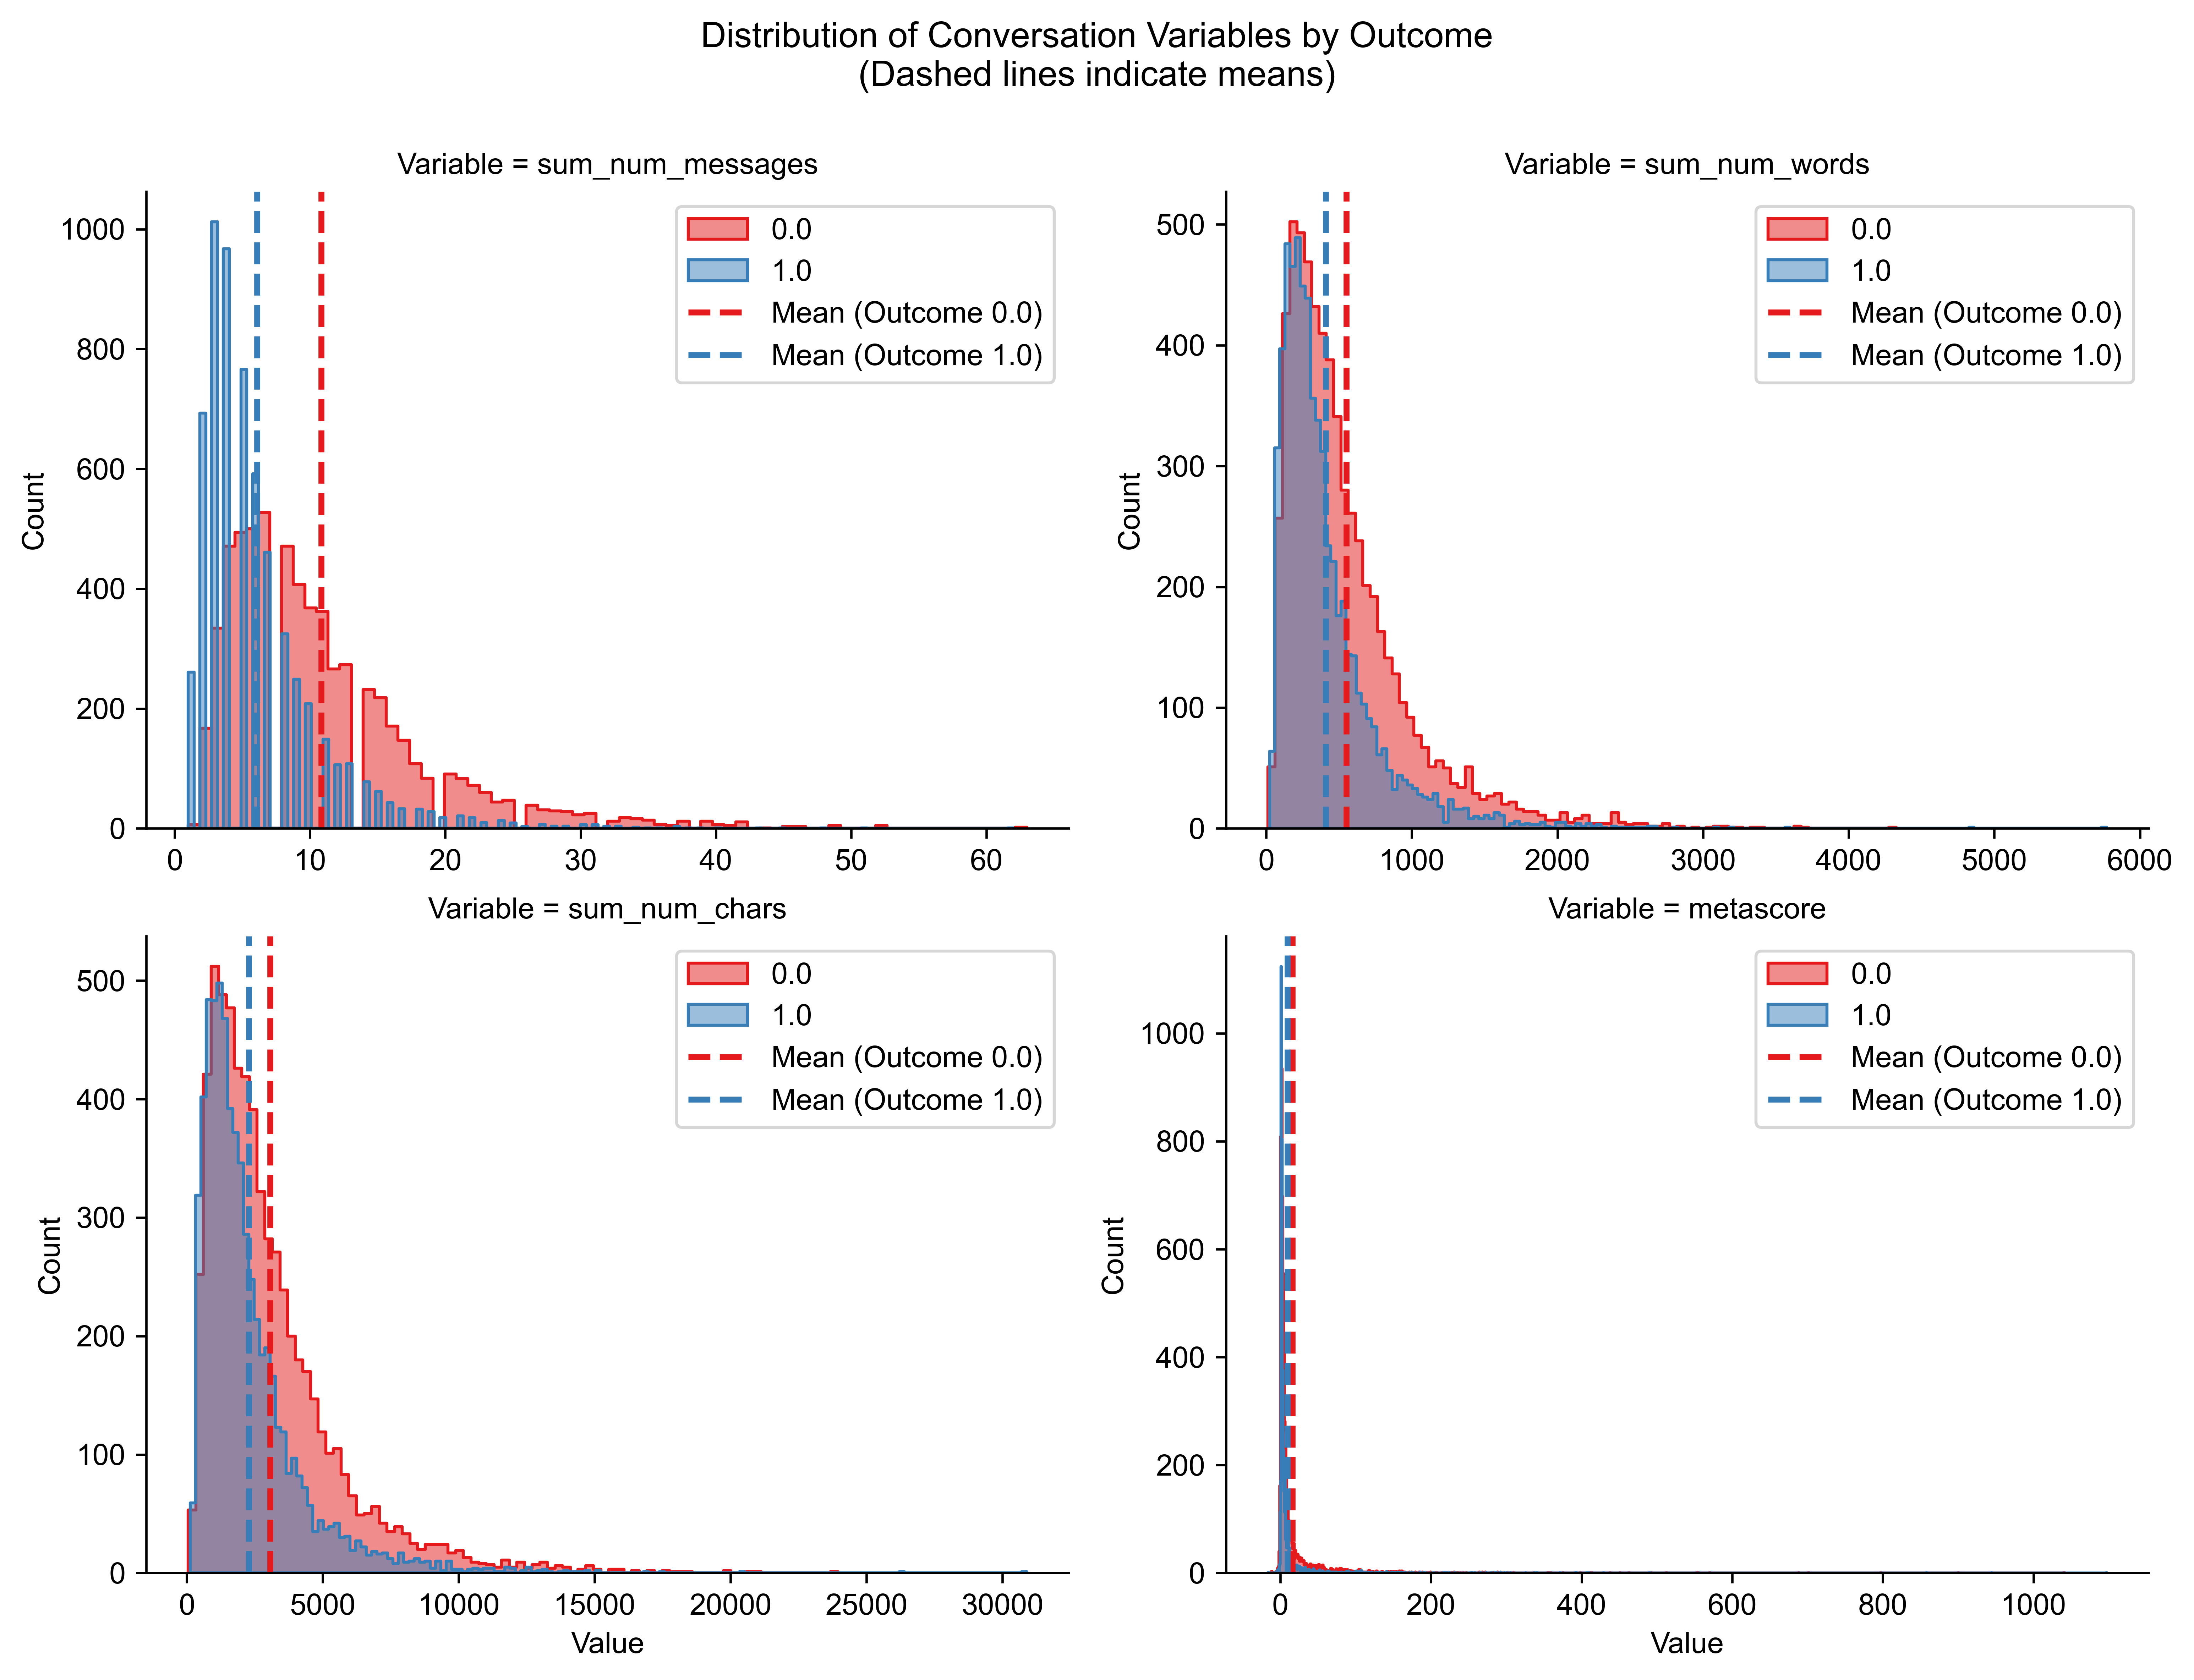

In [5]:
df_reddit_filtered = pd.read_csv('input-files/reddit_data.csv')
metascore_by_num = df_reddit_filtered[["conversation_num", "outcome", "metascore"]].drop_duplicates().groupby("conversation_num").mean().reset_index()


"""
Plot distributions: df_reddit_filtered was supposed to be filtered such that distributions are similar with respect to four
confounders, but empirically, this doesn't seem to be the case.

"""
def plot_confounder_distributions(df):
	 
	variables = ["sum_num_messages", "sum_num_words", "sum_num_chars", "metascore"]

	df_melt = df.melt(id_vars=['outcome'], value_vars=variables,
					var_name='Variable', value_name='Value')

	palette = sns.color_palette("Set1", n_colors=df['outcome'].nunique())

	g = sns.FacetGrid(df_melt, col="Variable", hue="outcome", col_wrap=2,
					sharex=False, sharey=False, height=4, aspect=1.3, palette=palette)
	g.map(sns.histplot, "Value", stat="count", alpha=0.5, element="step", kde=False)

	for variable, ax in zip(variables, g.axes.flat):
		for idx, outcome in enumerate(sorted(df['outcome'].unique())):
			vals = df.loc[df['outcome'] == outcome, variable]
			mean_val = vals.mean()
			ax.axvline(mean_val, color=palette[idx], linestyle='--', linewidth=2,
					label=f"Mean (Outcome {outcome})")
		# Remove duplicate legends
		handles, labels = ax.get_legend_handles_labels()
		by_label = dict(zip(labels, handles))
		ax.legend(by_label.values(), by_label.keys())

	plt.subplots_adjust(top=0.88)
	plt.suptitle("Distribution of Conversation Variables by Outcome\n(Dashed lines indicate means)")
	plt.show()

df_reddit_filtered_conv_metrics = reddit_combined[["conversation_num", "sum_num_messages", "sum_num_words", "sum_num_chars"]].merge(metascore_by_num, on ="conversation_num", how="left")
plot_confounder_distributions(df_reddit_filtered_conv_metrics)

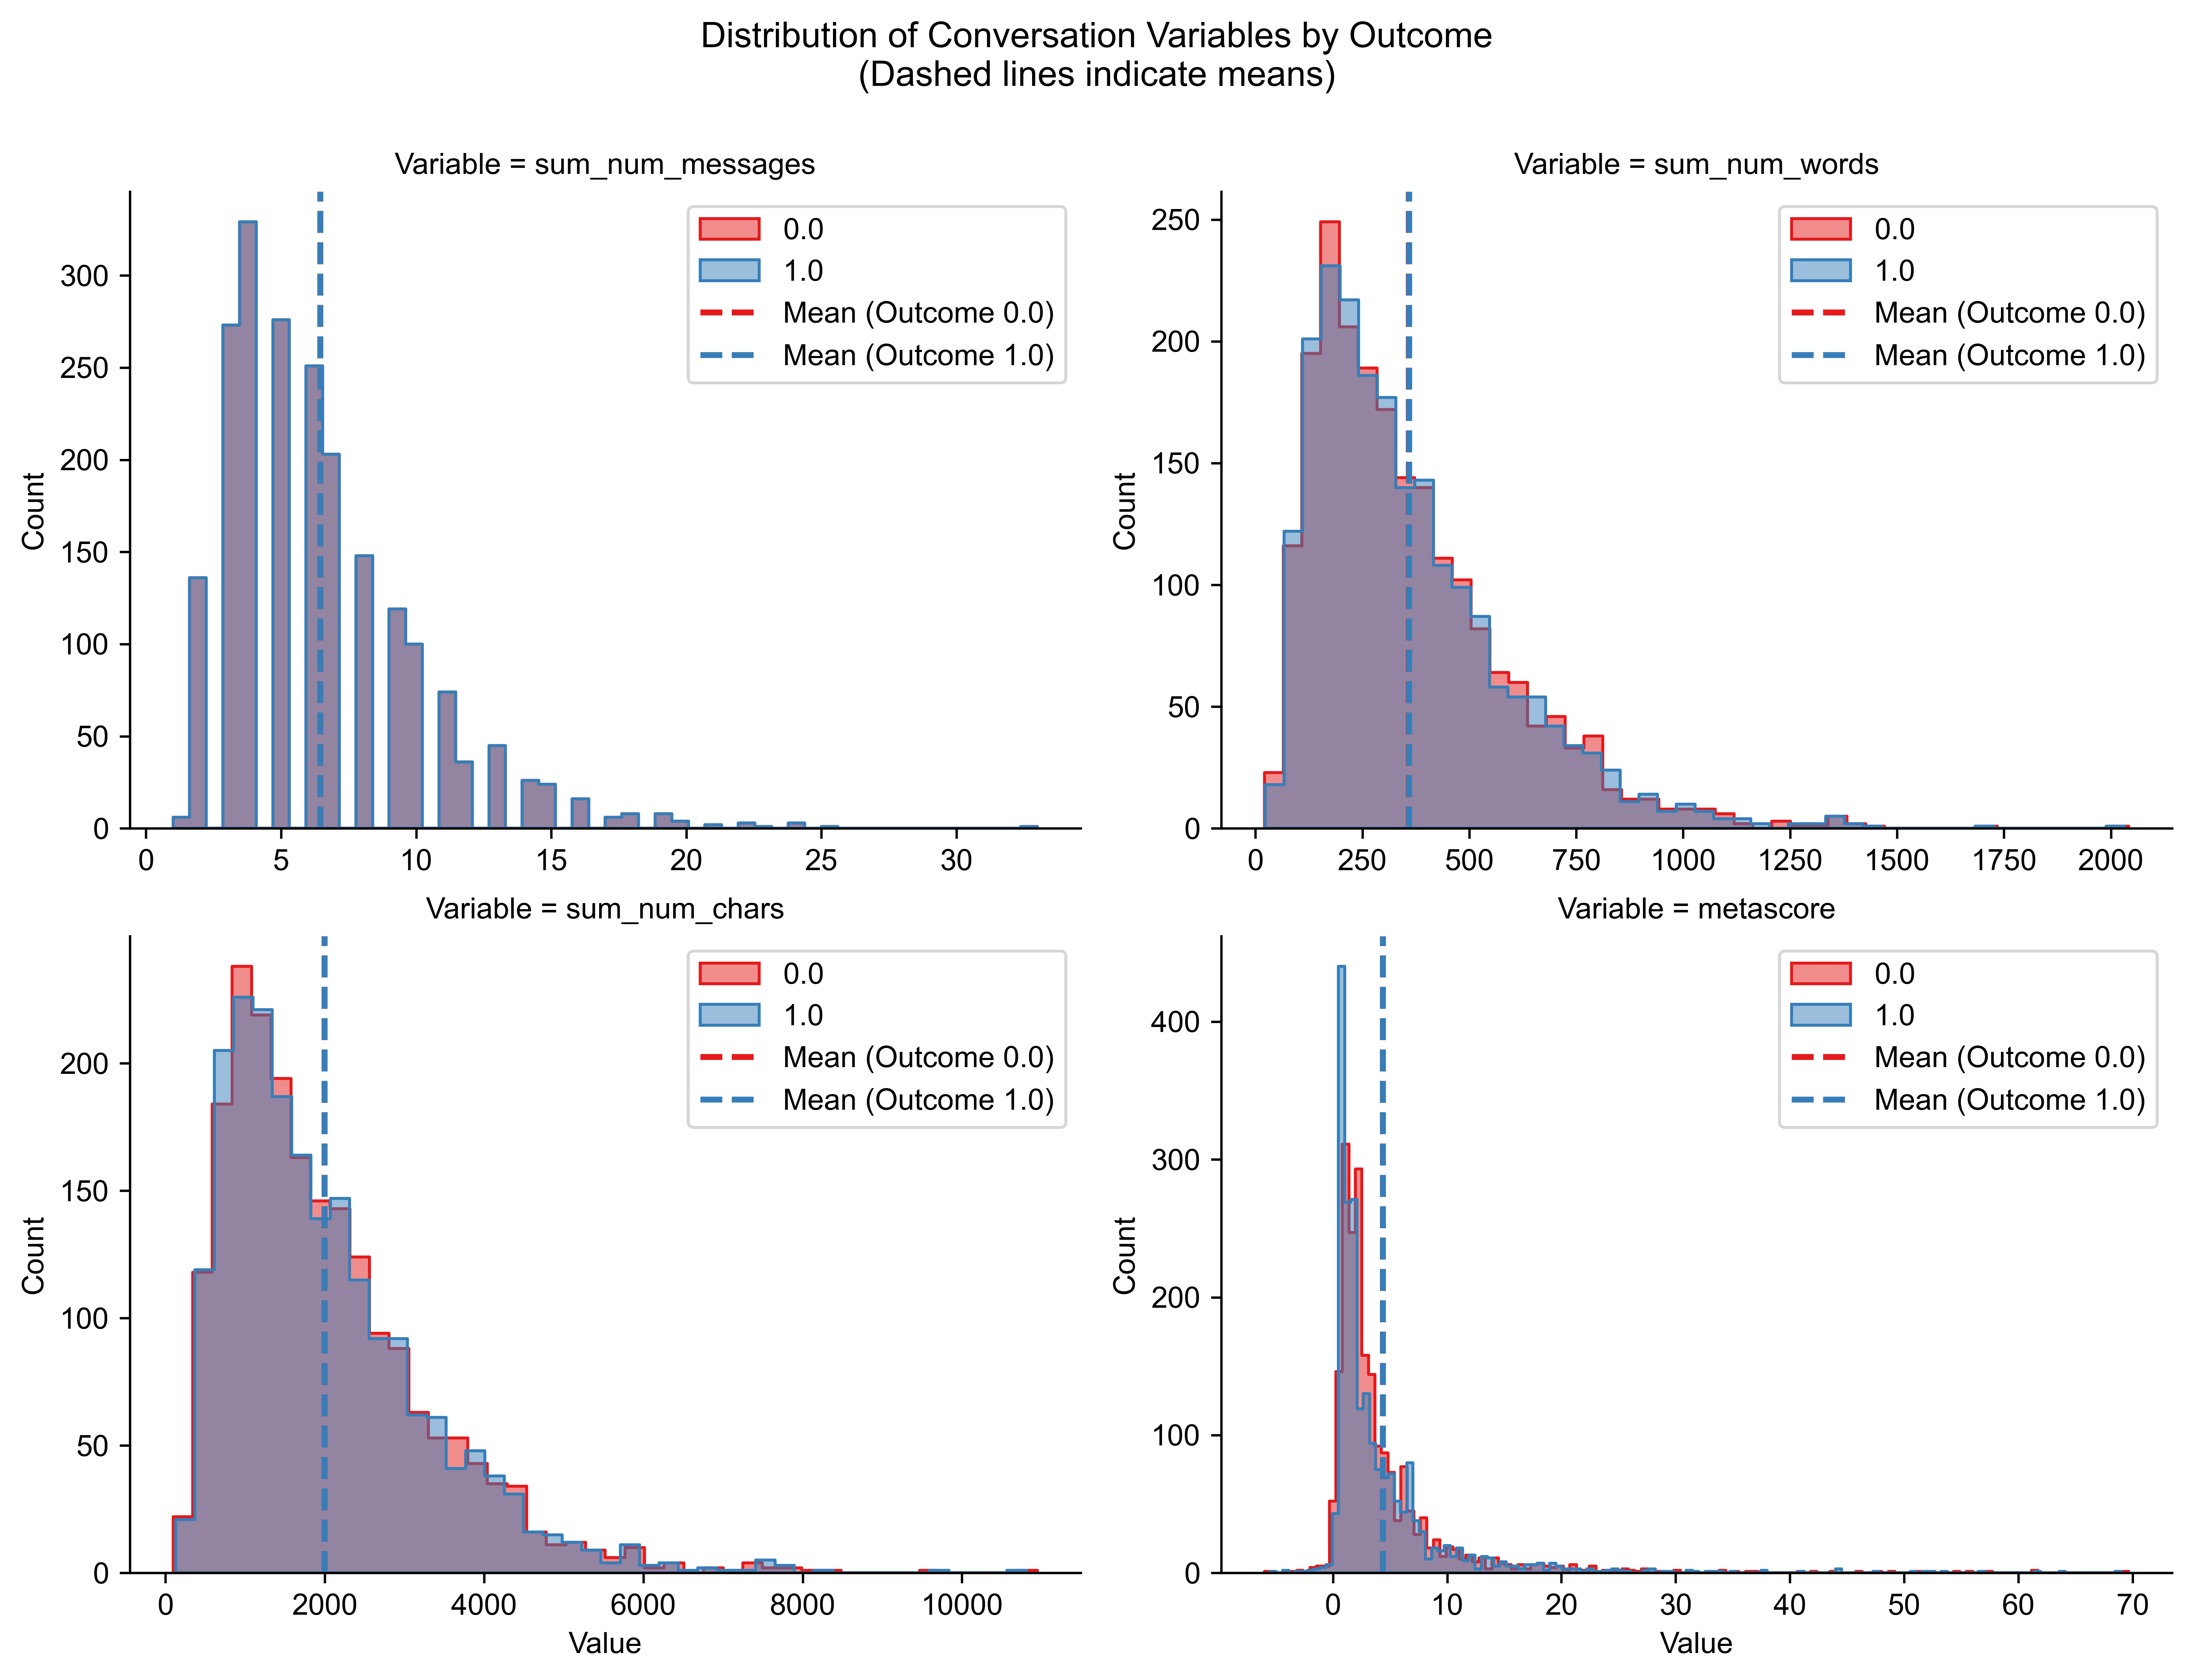

In [6]:
"""
Okay, let's fix the distributions by balancing the dataset with respect to these confounders.
"""

def balance_by_multivariable_bins_variable_width(df, variables, bin_widths, outcome_col='outcome', id_col='conversation_num', seed=42):
	np.random.seed(seed)
	df = df.copy()
	bin_cols = []
	for var in variables:
		width = bin_widths[var]
		bin_col = f"{var}_bin"
		df[bin_col] = (df[var] // width) * width
		bin_cols.append(bin_col)

	df["joint_bin"] = list(zip(*(df[col] for col in bin_cols)))

	sampled_ids = []
	grouped = df.groupby("joint_bin")
	for bin_val, group in grouped:
		group0 = group[group[outcome_col] == 0]
		group1 = group[group[outcome_col] == 1]
		min_count = min(len(group0), len(group1))
		if min_count > 0:
			samp_0 = np.random.choice(group0[id_col], size=min_count, replace=False)
			samp_1 = np.random.choice(group1[id_col], size=min_count, replace=False)
			sampled_ids.extend(samp_0)
			sampled_ids.extend(samp_1)

	balanced = df[df[id_col].isin(sampled_ids)].copy()
	balanced.drop(columns=bin_cols + ["joint_bin"], inplace=True)
	return balanced

variables = ["sum_num_messages", "sum_num_words", "sum_num_chars", "metascore"]
bin_widths = dict(df_reddit_filtered_conv_metrics[variables].describe().loc['std']/10)
df_reddit_balanced = balance_by_multivariable_bins_variable_width(
	df_reddit_filtered_conv_metrics,
	variables, bin_widths=bin_widths,
	outcome_col='outcome', id_col='conversation_num', seed=42
)

plot_confounder_distributions(df_reddit_balanced)

Make sure the dataset used for regression is also filtered

In [7]:
# now filter reddit data to only include conversations in the balanced dataset
reddit_combined = reddit_combined[reddit_combined['conversation_num'].isin(df_reddit_balanced['conversation_num'])]

### inspect the feature data

In [68]:
reddit_combined.shape, gpt_combined.shape

((4198, 152), (1200, 150))

In [8]:
reddit_combined.sample(10)

conversation_num  positive_bert  negative_bert  neutral_bert  num_words  \
1062            1557_A       0.046840       0.538995      0.414165  81.125000   
9782           dmxxb40       0.036500       0.506936      0.456565  53.000000   
1194            1626_A       0.083934       0.506583      0.409483  62.117647   
8347           dbcnhb6       0.008499       0.815447      0.176054  52.250000   
6342           cuveca9       0.051933       0.473768      0.474299  97.000000   
10794          duxn67t       0.144800       0.411298      0.443902  34.833333   
12120          e54vglk       0.038756       0.449222      0.512022  59.500000   
5927            4098_B       0.244185       0.176370      0.579444  57.200000   
4441            3333_B       0.063250       0.499846      0.436905  55.769231   
7638           d5kp8f9       0.013338       0.680726      0.305935  44.666667   

        num_chars  info_exchange_zscore_chats  \
1062   464.875000                    0.568242   
9782   298.230769                   -0.085466   
1194   337.411765                    0.155968   
8347   291.000000                   -0.100886   
6342   539.285714                    1.014815   
10794  195.500000                   -0.566257   
12120  307.666667                    0.053840   
5927   316.200000                   -0.039554   
4441   298.846154                   -0.038297   
7638   244.666667                   -0.287947   

       discrepancies_lexical_wordcount  hear_lexical_wordcount  \
1062                          1.625000                0.125000   
9782                          0.615385                0.000000   
1194                          2.647059                0.235294   
8347                          0.750000                0.500000   
6342                          4.000000                0.000000   
10794                         0.333333                0.000000   
12120                         2.333333                2.166667   
5927                          0.400000                0.800000   
4441                          1.923077                0.384615   
7638                          1.000000                0.333333   

       home_lexical_wordcount  ...  gini_coefficient_sum_num_words  \
1062                 0.000000  ...                        0.426040   
9782                 0.307692  ...                        0.165457   
1194                 0.000000  ...                        0.179924   
8347                 0.250000  ...                        0.366029   
6342                 0.000000  ...                        0.464654   
10794                0.000000  ...                        0.112440   
12120                0.000000  ...                        0.242764   
5927                 0.000000  ...                        0.283217   
4441                 0.000000  ...                        0.204828   
7638                 0.000000  ...                        0.395522   

       gini_coefficient_sum_num_chars  gini_coefficient_sum_num_messages  \
1062                         0.432778                           0.375000   
9782                         0.159230                           0.205128   
1194                         0.195432                           0.088235   
8347                         0.375430                           0.250000   
6342                         0.460000                           0.357143   
10794                        0.099318                           0.000000   
12120                        0.244131                           0.222222   
5927                         0.286211                           0.100000   
4441                         0.209653                           0.115385   
7638                         0.396458                           0.166667   

       turn_taking_index  team_burstiness  info_diversity  \
1062            0.142857         0.420204        0.633632   
9782            0.416667         0.231348        0.413802   
1194            0.312500         0.424521        0.34231

In [9]:
gpt_combined.sample(10)

conversation_num  positive_bert  negative_bert  \
635    escalatory_conversation_130       0.275096       0.410086   
342  deescalatory_conversation_407       0.283093       0.163981   
304  deescalatory_conversation_373       0.272038       0.257198   
982    escalatory_conversation_443       0.096661       0.551760   
421  deescalatory_conversation_479       0.391435       0.261239   
190  deescalatory_conversation_270       0.274327       0.231009   
402  deescalatory_conversation_461       0.349500       0.280994   
221  deescalatory_conversation_299       0.359656       0.128990   
809    escalatory_conversation_288       0.086117       0.594538   
967     escalatory_conversation_43       0.046037       0.596831   

     neutral_bert  num_words  num_chars  info_exchange_zscore_chats  \
635      0.314818  13.428571  76.714286                   -0.007507   
342      0.552926  12.307692  59.076923                   -0.350962   
304      0.470764  16.818182  84.909091                    0.668994   
982      0.351579  15.000000  85.214286                    0.396723   
421      0.347326  13.538462  69.923077                   -0.093724   
190      0.494665  10.555556  54.777778                   -0.787386   
402      0.369506  15.333333  81.916667                    0.255855   
221      0.511355  13.642857  66.142857                   -0.081004   
809      0.319345  13.066667  69.333333                   -0.104277   
967      0.357132  11.062500  58.750000                   -0.606962   

     discrepancies_lexical_wordcount  hear_lexical_wordcount  \
635                         0.071429                0.000000   
342                         0.230769                0.076923   
304                         0.272727                0.090909   
982                         0.214286                0.000000   
421                         0.307692                0.076923   
190                         0.277778                0.055556   
402                         0.250000                0.083333   
221                         0.642857                0.071429   
809                         0.400000                0.000000   
967                         0.437500                0.000000   

     home_lexical_wordcount  ...  gini_coefficient_sum_num_words  \
635                0.000000  ...                        0.015957   
342                0.000000  ...                        0.106250   
304                0.000000  ...                        0.057658   
982                0.000000  ...                        0.023810   
421                0.076923  ...                        0.005682   
190                0.000000  ...                        0.080702   
402                0.000000  ...                        0.021739   
221                0.000000  ...                        0.086387   
809                0.000000  ...                        0.010204   
967                0.000000  ...                        0.002825   

     gini_coefficient_sum_num_chars  gini_coefficient_sum_num_messages  \
635                        0.018622                           0.000000   
342                        0.125000                           0.038462   
304                        0.041399                           0.060606   
982                        0.025566                           0.000000   
421                        0.018152                           0.038462   
190                        0.102772                           0.074074   
402                        0.025941                           0.000000   
221                        0.091793                           0.000000   
809                        0.022115                           0.033333   
967                        0.022340                           0.000000   

     turn_taking_index  team_burstiness  info_diversity  discursive_diversity  \
635                1.0        -0.454454        0.423020              0.198646   
342                1.0        -0.381726        0.448573 

### Basic models (before we get to xgb)

#### utterance level (directness and oppositional intensity)

In [76]:
utterance_human_labels = pd.read_csv('input-files/CONFLICT_CONVO_LABELING_LOG.csv')

In [77]:
utterance_human_labels['CONV_ID'].nunique()

121

In [78]:
utterance_human_labels.shape

(2976, 9)

In [79]:
utterance_human_labels

CONV_ID            id rating_directness_content  \
0     d3j4tn9     d3j4tn9_1      Yes - Direct Content   
1     d3j4tn9     d3j4tn9_2      Yes - Direct Content   
2     d3j4tn9       d3jqp6d      Yes - Direct Content   
3     d3j4tn9       d3jtj7i      Yes - Direct Content   
4     d3j4tn9       d3ldu4f      Yes - Direct Content   
...       ...           ...                       ...   
2971   2941_B    t1_cqj299d      Yes - Direct Content   
2972   3636_A     t3_3g1fhs      Yes - Direct Content   
2973   3636_A  t1_cttxvho_1      Yes - Direct Content   
2974   3636_A  t1_cttxvho_2      Yes - Direct Content   
2975   3636_A  t1_cttxvho_3      Yes - Direct Content   

     rating_directness_expression                   rating_OI_content  \
0         Yes - Direct Expression  Yes - Content opposes someone else   
1         Yes - Direct Expression  Yes - Content opposes someone else   
2         Yes - Direct Expression  Yes - Content opposes someone else   
3         Yes - Direct Expression  Yes - Content opposes someone else   
4         Yes - Direct Expression  Yes - Content opposes someone else   
...                           ...                                 ...   
2971      Yes - Direct Expression  Yes - Content opposes someone else   
2972      Yes - Direct Expression  Yes - Content opposes someone else   
2973      Yes - Direct Expression  Yes - Content opposes someone else   
2974      Yes - Direct Expression  Yes - Content opposes someone else   
2975      Yes - Direct Expression  Yes - Content opposes someone else   

                           rating_OI_expression rater_id status  \
0        Yes - Expression is emotional/forceful      amy   done   
1     No - Expression is not emotional/forceful      amy   done   
2        Yes - Expression is emotional/forceful      amy   done   
3     No - Expression is not emotional/forceful      amy   done   
4        Yes - Expression is emotional/forceful      amy   done   
...                                         ...      ...    ...   
2971  No - Expression is not emotional/forceful   helena   done   
2972  No - Expression is not emotional/forceful   helena   done   
2973  No - Expression is not emotional/forceful   helena   done   
2974  No - Expression is not emotional/forceful   helena   done   
2975  No - Expression is not emotional/forceful   helena   done   

               last_updated_time  
0     2024-04-04 22:49:28.237198  
1     2024-04-04 22:49:29.146784  
2     2024-04-04 22:49:29.924042  
3     2024-04-04 22:49:30.680103  
4     2024-04-04 22:49:31.529325  
...                          ...  
2971  2024-04-05 10:48:50.839804  
2972  2024-04-05 10:48:51.426234  
2973  2024-04-05 10:48:52.083899  
2974  2024-04-05 10:48:52.783871  
2975  2024-04-05 10:48:53.397824  

[2976 rows x 9 columns]

In [92]:
for label in utterance_human_labels.filter(like="rating").columns:
    unique_counts_for_label = utterance_human_labels.groupby('id')[label].nunique().value_counts()
    total_labels = unique_counts_for_label.sum()
    unanimous_count = unique_counts_for_label.get(1, 0)

    print(f"Label: {label}")
    print(f"Unanimous pct: {unique_counts_for_label.get(1, 0) / total_labels:.2%}")

Label: rating_directness_content
Unanimous pct: 94.15%
Label: rating_directness_expression
Unanimous pct: 79.72%
Label: rating_OI_content
Unanimous pct: 86.18%
Label: rating_OI_expression
Unanimous pct: 79.62%


In [11]:
def str_to_binary(s):
	return 1 if "Yes" in s else 0

utterance_human_labels['rating_directness_content'] = utterance_human_labels['rating_directness_content'].apply(str_to_binary)
utterance_human_labels['rating_directness_expression'] = utterance_human_labels['rating_directness_expression'].apply(str_to_binary)
utterance_human_labels['rating_OI_content'] = utterance_human_labels['rating_OI_content'].apply(str_to_binary)
utterance_human_labels['rating_OI_expression'] = utterance_human_labels['rating_OI_expression'].apply(str_to_binary)

In [12]:
# group by CONV_ID and id
utterance_human_labels = utterance_human_labels[['CONV_ID', 'id', 'rating_directness_content', 'rating_directness_expression', 'rating_OI_content', 'rating_OI_expression']].groupby(['CONV_ID', 'id']).mean().reset_index()

In [13]:
df_labeled_utterances = utterance_human_labels.merge(df_reddit_orig, on = ["CONV_ID", "id"], how='left')

# filter out ORIGINAL_POSTs
assert len(df_labeled_utterances[df_labeled_utterances["reply_to"] == "ORIGINAL_POST"]) == 0, "There are still ORIGINAL_POSTs in the utterance_human_labels dataframe."

# drop nas
df_labeled_utterances = df_labeled_utterances.dropna()

In [ ]:
# binarize "rated" cols to be either 1 (unanimously 1) or 0 (otherwise)
def binarize_unanimous_one(df, cols):
	for col in cols:
		df[col] = np.where(df[col] == 1, 1, 0)
	return df

df_labeled_utterances = binarize_unanimous_one(
	df_labeled_utterances,
	df_labeled_utterances.filter(like='rating_').columns.tolist()
)

array([[<Axes: title={'center': 'rating_directness_content'}>,
        <Axes: title={'center': 'rating_directness_expression'}>],
       [<Axes: title={'center': 'rating_OI_content'}>,
        <Axes: title={'center': 'rating_OI_expression'}>]], dtype=object)

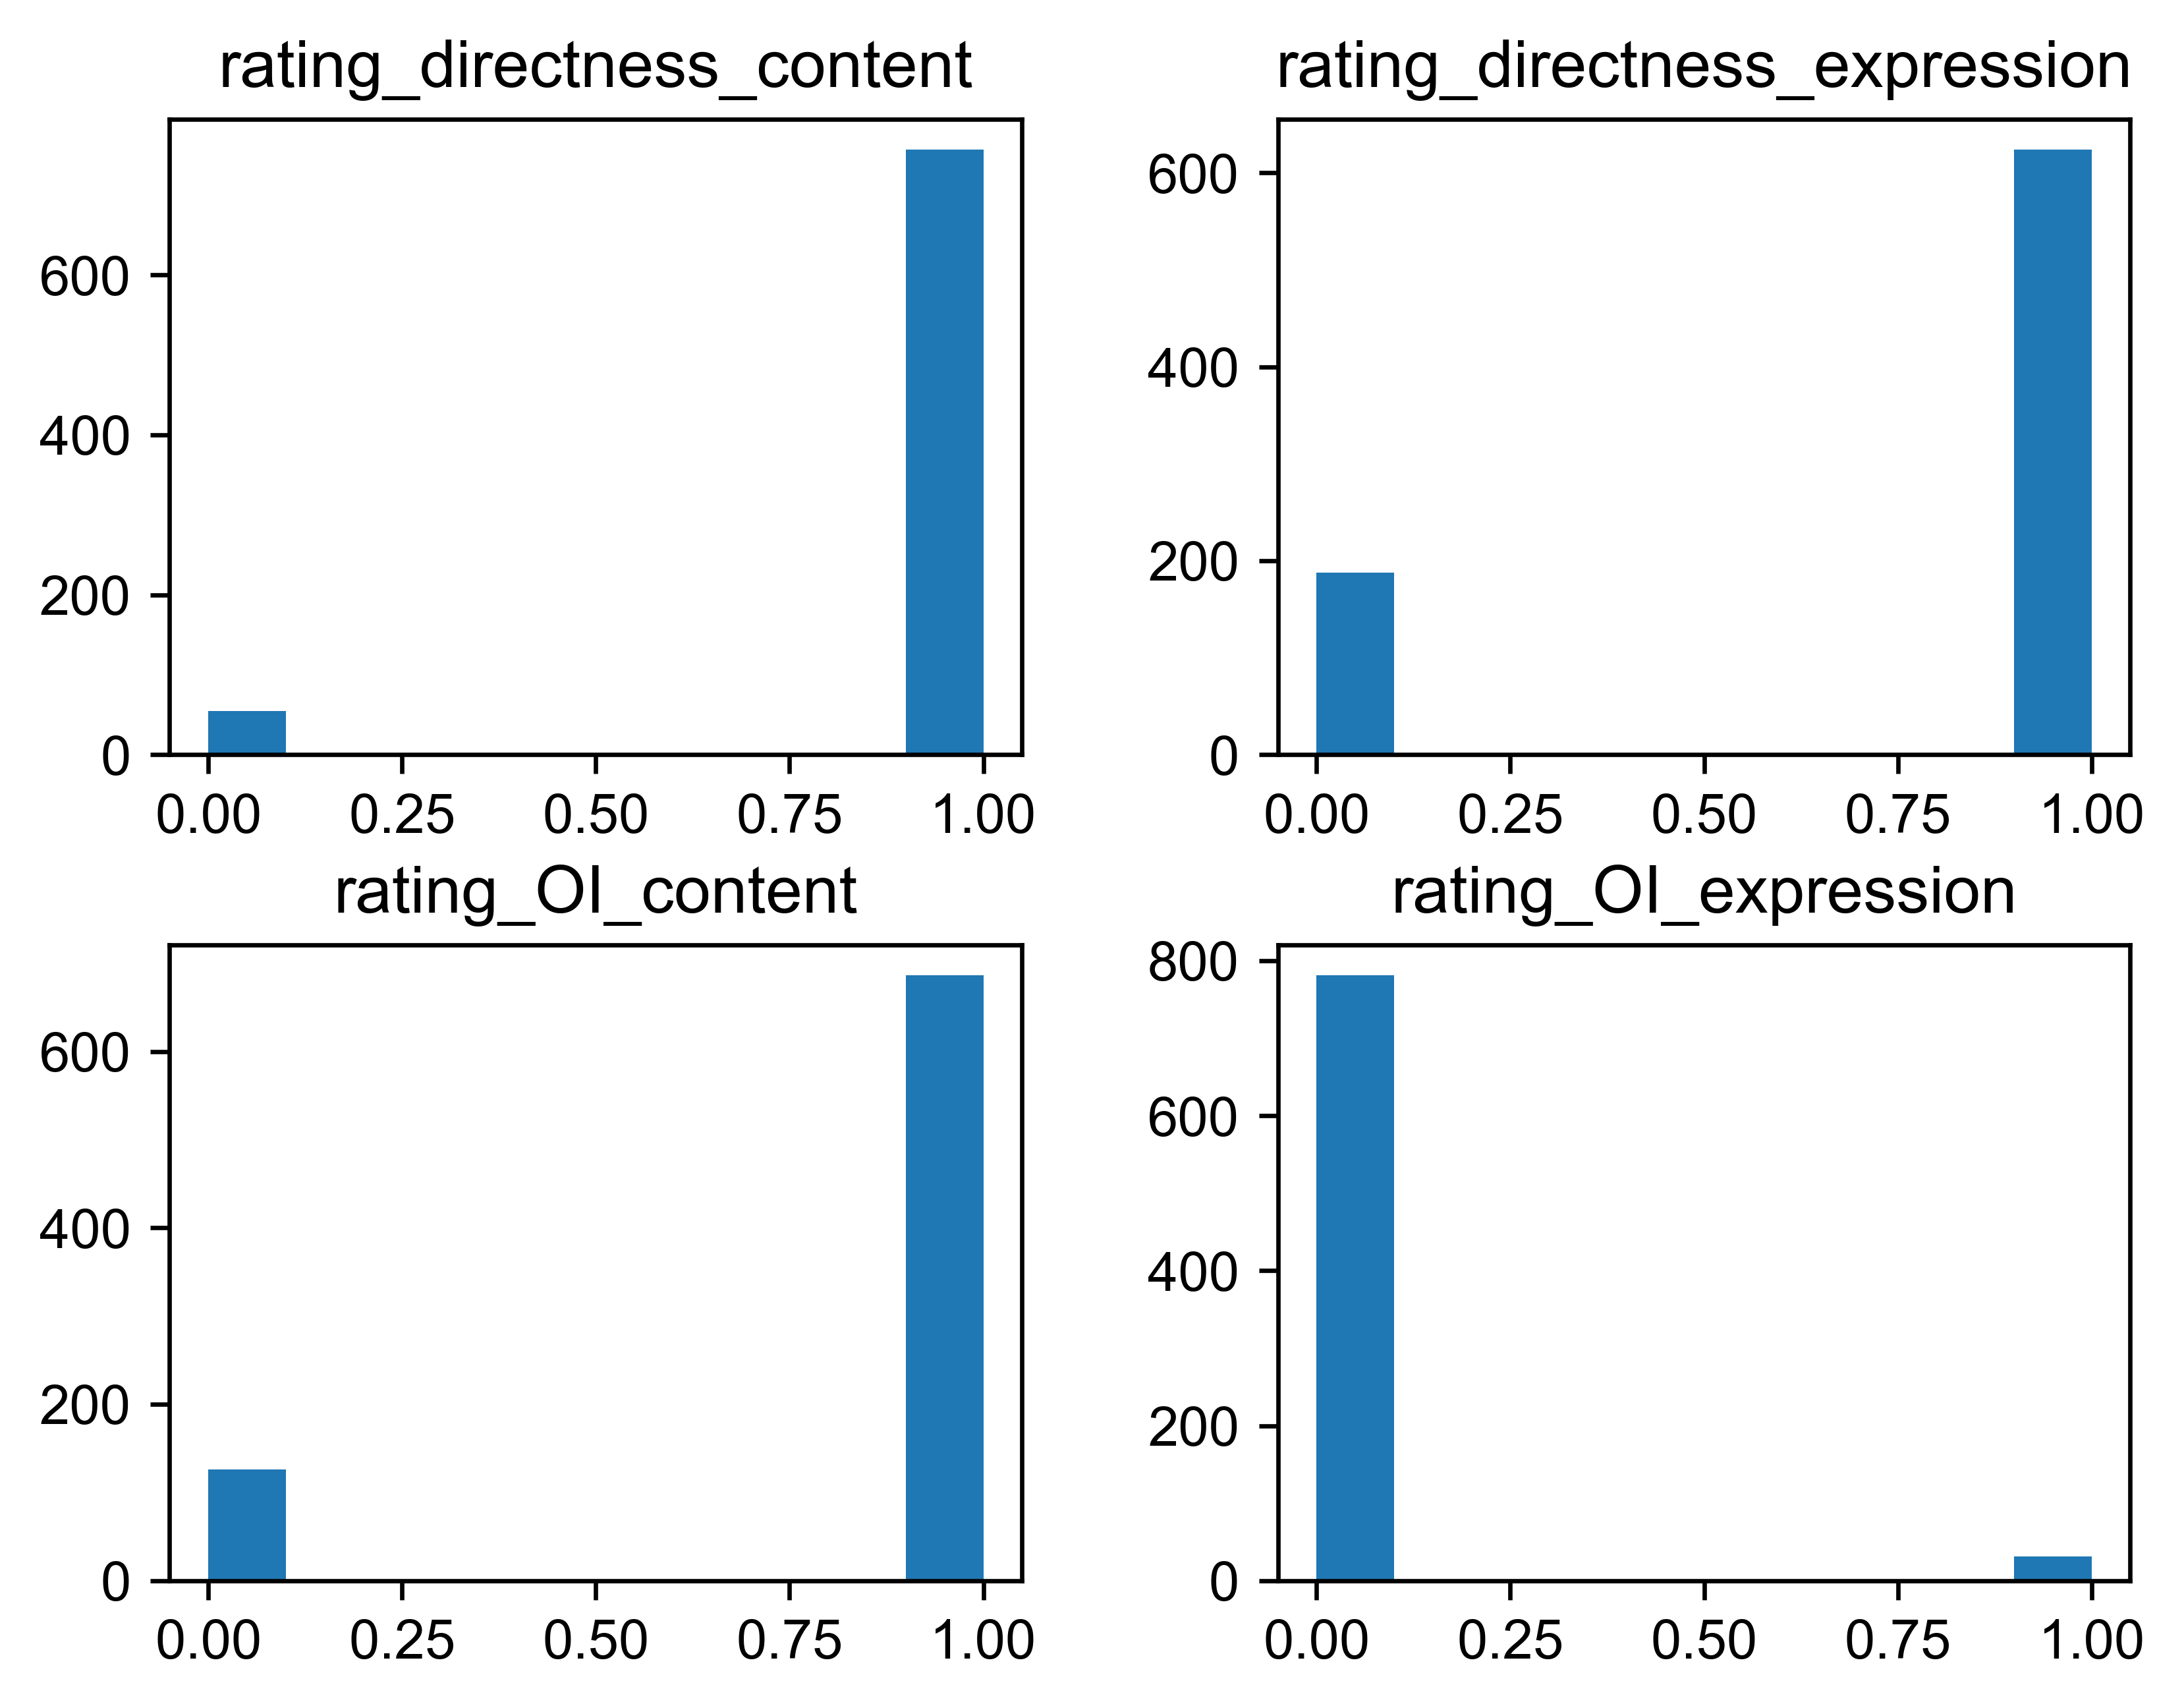

In [15]:
df_labeled_utterances.filter(like="rating").hist() ### our distributions are a little skewed towards being direct but not very intense

In [16]:
# this means we need to do some balancing...
def per_column_balanced_dfs(df, label_columns, sample_pct = 0.7, seed=42):
	np.random.seed(seed)
	balanced_dfs = {}
	for col in label_columns:
		zeros = df[df[col] == 0]
		ones = df[df[col] == 1]
		n = int(min(len(zeros), len(ones)) * sample_pct)
		if n == 0:
			balanced_dfs[col] = pd.DataFrame(columns=df.columns)
		else:
			balanced = pd.concat([
				zeros.sample(n, random_state=seed),
				ones.sample(n, random_state=seed)
			]).sample(frac=1, random_state=seed).reset_index(drop=True)
			balanced_dfs[col] = balanced
	return balanced_dfs

dfs = per_column_balanced_dfs(df_labeled_utterances, [
		"rating_directness_content",
		"rating_directness_expression",
		"rating_OI_content",
		"rating_OI_expression"
	], seed=42)

for col, dfx in dfs.items():
	print(col, dfx[col].value_counts())

rating_directness_content rating_directness_content
0    38
1    38
Name: count, dtype: int64
rating_directness_expression rating_directness_expression
1    131
0    131
Name: count, dtype: int64
rating_OI_content rating_OI_content
0    88
1    88
Name: count, dtype: int64
rating_OI_expression rating_OI_expression
1    21
0    21
Name: count, dtype: int64


# Predictions

#### Can we predict directness and oppositional intensity?

In [17]:
df_labeled_utterances['text'] = df_labeled_utterances['text'].astype(str)
df_labeled_utterances.sort_values(by=['CONV_ID', 'id', 'timestamp'], inplace=True)
df_labeled_utterances['timestamp'] = pd.to_datetime(df_labeled_utterances['timestamp'], unit='ns', utc=True)
df_labeled_utterances.reset_index(drop=True, inplace=True)

In [18]:
try:
	df_utterances_featurized = pd.read_csv('output/chat/labeled_utterances_reddit_chat_level.csv')

except FileNotFoundError:
	# first, run the feature builder on the labeled utterances
	labeled_reddit_feature_builder = FeatureBuilder(
		input_df=df_labeled_utterances,
		custom_features=[
			"(BERT) Mimicry",
			"Moving Mimicry",
			"Forward Flow",
			"Discursive Diversity"
		],
		conversation_id_col="CONV_ID",
		speaker_id_col="speaker",
		message_col="text",
		timestamp_col="timestamp",
		vector_directory="./vector_data/",
		output_file_base="labeled_utterances_reddit",
		timestamp_unit='ns'    
	)
	labeled_reddit_feature_builder.featurize()

### Column Cleanup -- drop correlated features

In [19]:
def get_highly_correlated_pairs(df, threshold=0.95):
	corrmat = df.corr().abs()
	pairs = []
	cols = corrmat.columns
	for i in range(len(cols)):
		for j in range(i + 1, len(cols)):
			if corrmat.iloc[i, j] > threshold:
				pairs.append((cols[i], cols[j], corrmat.iloc[i, j]))
	return pairs

In [20]:
def drop_correlated_features(df, cols, threshold=0.95):

	# get the pairs of highly correlated features (from the target cols)
	pairs = get_highly_correlated_pairs(df[cols], threshold)
	if len(pairs) == 0:
		print("No highly correlated pairs found.")
		return df

	df_new = df.copy()
	# drop the target columns from the dataframe
	df_new.drop(columns=cols, inplace=True)
	new_cols = df[cols].copy()

	for col1, col2, _ in pairs:
		if col1 in new_cols.columns and col2 in new_cols.columns:
			new_cols.drop(columns=[col2], inplace=True)
	
	return pd.concat([df_new, new_cols], axis=1), list(new_cols.columns)

In [21]:
df_utterances_featurized, new_utt_level_features = drop_correlated_features(df_utterances_featurized,
						 CHAT_LEVEL_FEATURES,
						 threshold=0.95)

In [22]:
reddit_combined, new_features_reddit = drop_correlated_features(reddit_combined,
						 CHAT_LEVEL_FEATURES + CONV_LEVEL_FEATURES,
						 threshold=0.95)

In [23]:
gpt_combined, new_features_gpt = drop_correlated_features(gpt_combined,
						 CHAT_LEVEL_FEATURES + CONV_LEVEL_FEATURES,
						 threshold=0.95)

In [24]:
# having dropped the correlated features, we need to update the feature lsts
CHAT_LEVEL_FEATURES = new_utt_level_features

### Predict Directness and OI

In [25]:
BOOTSTRAPS = 1000
BASE_SEED = 42

outcomes = [
	"rating_directness_content", 
	"rating_directness_expression",
	"rating_OI_content", 
	"rating_OI_expression"
]

try:
	# load existing results if available
	with open('output/predict_utt_labels_coef_dfs.pkl', 'rb') as f:
		coef_dfs = pickle.load(f)
		print(f"Loaded {len(coef_dfs)} coefficient dataframes from previous runs.")
	with open('output/predict_utt_labels_results.pkl', 'rb') as f:
		results = pickle.load(f)
		print(f"Loaded {len(results)} results from previous runs.")
	with open('output/predict_utt_labels_model_records.pkl', 'rb') as f:
		model_records = pickle.load(f)
		print(f"Loaded {len(model_records)} model records from previous runs.")

except FileNotFoundError:
	
	print("Could not load pickled results, starting fresh.")
	
	results = []
	coef_dfs = []
	model_records = []

	for i in tqdm(range(BOOTSTRAPS), desc="Bootstrapping CV's"):
		# Get a new random sample of balanced dataframes for each outcome on this bootstrap
		dfs = per_column_balanced_dfs(df_labeled_utterances, outcomes, seed=BASE_SEED + i)

		for outcome in outcomes:
			# The balanced df for this outcome, must merge with features on 'id'
			sample = dfs[outcome]
			if sample.empty or sample[outcome].nunique() < 2:
				continue

			# Merge with features
			merged = sample.merge(df_utterances_featurized[['id'] + CHAT_LEVEL_FEATURES], on='id', how='inner')

			# In every iteration, train on 80% and test on 20%
			X = merged[CHAT_LEVEL_FEATURES]
			y = merged[outcome]
			X_train, X_test, y_train, y_test = train_test_split(
				X, y, test_size=0.2, random_state=BASE_SEED + i, stratify=y
			)

			model = Pipeline([
				('scaler', StandardScaler()),  # Standardize features
				('clf', LogisticRegressionCV(
					cv=5,
					max_iter=2000,
					random_state=BASE_SEED + i,
					penalty='elasticnet',
					l1_ratios=[.2, .5, .8, 1.0],
					scoring='f1',
					n_jobs=-1,
					solver='saga',
					Cs=10,  # Cross-validate over 10 strengths for C (inverse regularization)
					refit=True
				))
			])

			try:
				model.fit(X_train, y_train)
				y_pred = model.predict(X_test)

				# Save the model and predictions for this bootstrap
				model_records.append({
					'outcome': outcome,
					'bootstrap': i,
					'model': model,
					'X_test': X_test,
					'y_test': y_test,
					'y_pred': y_pred
				})
				# Save F1 score and coefficients
				f1 = f1_score(y_test, y_pred)
				results.append({
					'outcome': outcome,
					'bootstrap': i,
					'f1_score': f1
				})
				coefs = model.named_steps['clf'].coef_.ravel()
				coef_df = pd.DataFrame({
					'feature': CHAT_LEVEL_FEATURES,
					'coef': coefs,
					'outcome': outcome,
					'bootstrap': i
				})
				coef_dfs.append(coef_df)
			except Exception as e:
				print(f"Error training model for outcome {outcome} on bootstrap {i}: {e}")
				continue

Loaded 4000 coefficient dataframes from previous runs.
Loaded 4000 results from previous runs.
Loaded 4000 model records from previous runs.


In [26]:
# save coef_dfs and results to pkl files
with open('output/predict_utt_labels_coef_dfs.pkl', 'wb') as f:
	pickle.dump(coef_dfs, f)
with open('output/predict_utt_labels_results.pkl', 'wb') as f:
	pickle.dump(results, f)
with open('output/predict_utt_labels_model_records.pkl', 'wb') as f:
	pickle.dump(model_records, f)

print("saved results and coefficient dataframes.")

saved results and coefficient dataframes.


In [27]:
# Combine and summarize
coef_long = pd.concat(coef_dfs, ignore_index=True)
f1_df = pd.DataFrame(results)

pretty_names = {
	"rating_directness_expression": "Directness (Expression)",
	"rating_directness_content": "Directness (Content)",
	"rating_OI_expression": "Oppositional Intensity (Expression)",
	"rating_OI_content": "Oppositional Intensity (Content)"
}
coef_long["Label"] = coef_long["outcome"].map(pretty_names)
f1_df["Label"] = f1_df["outcome"].map(pretty_names)

set the color palette for plotting

In [28]:
CONV_OUTCOME_NAME = "Successful De-Escalation"

palette = sns.color_palette("Dark2", n_colors=len(pretty_names.values()) + 1)
hue_names = list(pretty_names.values()) + [CONV_OUTCOME_NAME]
label_to_color = dict(zip(hue_names, palette))
pretty_names[CONV_OUTCOME_NAME] = CONV_OUTCOME_NAME

In [29]:
def plot_coefficients(coef_long, plot_name, top_n_features=None, label_to_color=label_to_color,
					  title = "ElasticNet Coefficients"):
	# 1. Significance filter
	interesting_features = []
	for feature in coef_long['feature'].unique():
		keep = False
		for label in coef_long['Label'].unique():
			data = coef_long[
				(coef_long['feature'] == feature) & 
				(coef_long['Label'] == label)
			]['coef']
			if len(data) > 1:
				tstat, pval = ttest_1samp(data, popmean=0)
				if pval < 0.01:
					keep = True
		if keep:
			interesting_features.append(feature)

	# 2. Subset and pad
	features_to_plot = interesting_features
	labels_to_plot = list(coef_long["Label"].unique())
	pad = []
	for feature in features_to_plot:
		for label in labels_to_plot:
			mask = (coef_long['feature']==feature) & (coef_long['Label']==label)
			if not mask.any():
				pad.append({
					"feature": feature,
					"coef": np.nan,
					"Label": label
				})
	coef_plot = pd.concat([coef_long[coef_long['feature'].isin(features_to_plot)], pd.DataFrame(pad)], ignore_index=True)

	# Compute means and standard errors for each (feature, Label)
	summary = coef_plot.groupby(['feature', 'Label'])['coef'].agg(['mean', 'sem']).reset_index()

	# Compute Cohen's d for each (feature, label)
	feature_label_ds = (
		coef_plot
		.groupby(['feature', 'Label'])['coef']
		.agg(lambda x: np.nanmean(x) / np.nanstd(x) if np.nanstd(x) > 0 else 0)
		.unstack()
		.abs()
	)
	# Max absolute d across labels
	cohens_d_max = feature_label_ds.max(axis=1)
	ordering = cohens_d_max.sort_values(ascending=False).index.tolist()
		# Apply feature limit IF SPECIFIED
	if (top_n_features is not None) and (top_n_features > 0):
		ordering = ordering[:top_n_features]
	summary = summary[summary['feature'].isin(ordering)]
	summary['feature'] = pd.Categorical(summary['feature'], categories=ordering, ordered=True)

	plt.figure(figsize=(13, max(8, len(ordering))))
	hue_offsets = np.linspace(-0.15, 0.15, len(hue_names))  # for y-axis jitter

	# Error bars = 95% CI from (possibly bootstrapped) data
	for i, feature in enumerate(ordering):
		for j, label in enumerate(hue_names):
			this_vals = coef_plot[
				(coef_plot['feature']==feature) &
				(coef_plot['Label']==label)
			]['coef'].dropna()
			if len(this_vals):
				mu = this_vals.mean()
				ci_low = np.percentile(this_vals, 2.5)
				ci_high = np.percentile(this_vals, 97.5)
				# Clamp (mu-ci_low) and (ci_high-mu) to ≥0
				left = max(mu - ci_low, 0) # xerr = left error
				right = max(ci_high - mu, 0) # xerr = right error
				if left == 0 and right == 0:
					# warn or continue if desired
					pass
				err = np.array([[left], [right]])
				plt.errorbar(
					mu, i + hue_offsets[j], xerr=err, fmt='o',
					color=label_to_color[label],
					label=label if i == 0 else "",
					capsize=6, markersize=8, elinewidth=2
				)
	plt.axvline(0, color='black', lw=1, linestyle='--')
	plt.yticks(range(len(ordering)), ordering, fontsize=14)
	plt.xticks(fontsize=14)
	plt.xlabel("Coefficient (Error bars are 95% CI)", fontsize=14)
	plt.title(f"{title}\n(Top features by effect size; Error bars are 95% CI)", fontsize=16)
	plt.tight_layout(rect=[0, 0.13, 1, 1])
	plt.legend(
		title="", loc='upper center',
		bbox_to_anchor=(0.5, -0.05),
		ncol=len(hue_names), frameon=False,
		fontsize = 14
	)
	plt.savefig(f'output/{plot_name}.pdf', bbox_inches='tight')
	plt.savefig(f'output/{plot_name}.png', bbox_inches='tight')
	plt.show()

In [30]:
plot_coefficients(coef_long, 
				  "utterance_level_feature_coefficients",
				  top_n_features=15,
                  title = "ElasticNet Coefficients for Utterance-Level Features, Colored by Predicted Label (Directness/Oppositional Intensity)")

How do we interpret something from this? Inspect the features...

In [31]:
def get_top_messages_for_feature(df, feature_name, top_n=10):
	"""
	Show the top N messages for a given feature.
	"""
	top_messages = df.nlargest(top_n, feature_name)[['text_original', 'speaker', feature_name, 'rating_directness_content', 'rating_directness_expression', 'rating_OI_content', 'rating_OI_expression']]
	return top_messages

In [32]:
get_top_messages_for_feature(df_utterances_featurized, "negation_lexical_wordcount", top_n=20).sample(5)["text_original"].tolist()

["Does your vote have to make a difference for it to be worth your time? I disagree with this stance personally. I vote as long as I think I am submitting to a cause I believe is the correct one. In our society, hardly anything most individuals do has a direct influence. To say that what you do does not have an influence on the whole can rationalize a lot of behavior - not behaving ecologically, not voting, throwing specific trash (e.g. medicine, electronics, batteries) to mixed waste etc. Why do you give money to charity? You think these few dollars a month will make a difference? Why do you recycle? You think a few bottles of plastic will make a difference in the billions of tons of plastic waste? Why do you vote? You think one vote will change the functioning of the country? All these come down to excusing and rationalizing not doing something to feel better. To me, that is sloth. Not voting because you don't think it's worth your time is intellectual sloth in my eyes, as long as yo

#### F1 Plot

In [33]:
def plot_f1_scores_by_label(
	model_records, 
	f1_df, 
	pretty_names, 
	label_to_color,
	plot_name,
	title="Out-of-Sample Prediction for Message Labels",
	f1_cutoff=0.5,
	figsize=(7,7)
):
	"""
	Plots boxplots of F1 scores per label, overlaying the "global" F1 using all out-of-sample predictions.
	Shows only labels for which there is data.
	"""
	# Which *display* labels are present in your results? (robust to multi-label and single-label)
	# f1_df['Label'] must contain pretty label names (not codes!)
	labels_with_data = list(pd.unique(f1_df['Label']))
	plot_labels = [l for l in pretty_names.values() if l in labels_with_data]

	# Aggregate/global F1: only for present labels
	all_labels = sorted(set(rec['outcome'] for rec in model_records))
	pretty_name_map = pretty_names
	global_f1s = []
	for label in all_labels:
		y_true_all, y_pred_all = [], []
		for rec in model_records:
			if rec['outcome'] == label:
				y_true_all.append(np.array(rec['y_test']))
				y_pred_all.append(np.array(rec['y_pred']))
		if y_true_all:
			y_true_concat = np.concatenate(y_true_all)
			y_pred_concat = np.concatenate(y_pred_all)
			f1_global = f1_score(y_true_concat, y_pred_concat)
			global_f1s.append(dict(
				Label=pretty_name_map.get(label, label),
				global_f1=f1_global,
				n_test=len(y_true_concat)
			))
	global_f1_df = pd.DataFrame(global_f1s)
	# only keep rows present in those to plot
	global_f1_df = global_f1_df[global_f1_df['Label'].isin(plot_labels)]

	plt.figure(figsize=figsize)
	box = sns.boxplot(
		data=f1_df, 
		x='Label', y='f1_score', 
		order=plot_labels,
		palette=label_to_color
	)
	plt.axhline(f1_cutoff, color='red', linestyle='--', lw=2, alpha=0.7)

	# Overlay global F1 points for each outcome/label (only those in 'plot_labels')
	for i, label in enumerate(plot_labels):
		global_row = global_f1_df[global_f1_df['Label'] == label]
		if not global_row.empty:
			global_val = global_row['global_f1'].iloc[0]
			plt.scatter(
				i, global_val,
				marker='D',
				color=label_to_color[label],
				s=125, linewidth=2, edgecolor='k', zorder=5,
				label=f'{global_val:.2f}'
			)

	# Legend: only show global F1s for plotted labels (no repeats)
	handles, labels = plt.gca().get_legend_handles_labels()
	seen = set()
	new_handles, new_labels = [], []
	for h, l in zip(handles, labels):
		if l not in seen:
			seen.add(l)
			new_handles.append(h)
			new_labels.append(l)
	plt.legend(new_handles, new_labels,
			   title='Global F1 (All Folds)', loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)

	plt.ylabel('F1 Score', fontsize=12)
	plt.xlabel('')
	plt.title(title, fontsize=12)
	# Only show xticks for the actually plotted labels:
	plt.xticks(ticks=range(len(plot_labels)), labels=plot_labels, rotation=45, ha="right", fontsize=12)
	plt.tight_layout()

	plt.savefig(f'output/{plot_name}.pdf', bbox_inches='tight')
	plt.savefig(f'output/{plot_name}.png', bbox_inches='tight')	
	plt.show()

In [34]:
plot_f1_scores_by_label(
	model_records=model_records,
	f1_df=f1_df,
	pretty_names=pretty_names,
	label_to_color=label_to_color,
	plot_name="utterance_level_f1_scores",
	title="Out-of-Sample Prediction for Directness and Oppositional Intensity Labels\n(1,000 Bootstraps, 80-20 Train/Test)",
)

#### conversation level (outcomes)

In [35]:
def bootstrap_regularized_logistic(
	df,
	outcome_col,
	feature_cols,
	pkl_file_paths,
	n_bootstraps=1000,
	base_seed=42
):
	"""
	Args:
		df: pd.DataFrame
		outcome_col: str (binary outcome column)
		feature_cols: list of str
		pkl_file_paths: list of 3 str [results.pkl, coefs.pkl, models.pkl]
		n_bootstraps: int
		base_seed: int (random seed)
	Returns:
		results, coef_dfs, model_records  [list, list, list]
	"""
	results_path, coefs_path, models_path = pkl_file_paths

	# Try to load if possible
	if all([os.path.exists(p) for p in pkl_file_paths]):
		try:
			with open(results_path, 'rb') as f:
				results = pickle.load(f)
			with open(coefs_path, 'rb') as f:
				coef_dfs = pickle.load(f)
			with open(models_path, 'rb') as f:
				model_records = pickle.load(f)
			print(f"Loaded pickled outputs from {results_path}, {coefs_path}, {models_path}")
			return results, coef_dfs, model_records
		except Exception as e:
			print("Could not load pickled results (recomputing):", e)

	# Otherwise, run the loop
	results = []
	coef_dfs = []
	model_records = []

	for i in tqdm(range(n_bootstraps), desc='Bootstrapping'):
		
		def fill_inf_and_na_with_zero(df):
			# Replace inf and -inf with NaN, then fill all NaN with 0
			return df.replace([np.inf, -np.inf], np.nan).fillna(0)

		df_nonan = fill_inf_and_na_with_zero(df[[outcome_col] + feature_cols])

		if df_nonan[outcome_col].nunique() != 2:
			print(f"Skipping bootstrap {i}: outcome is not binary")
			continue

		# Sample with replacement (bootstrap) for this iteration
		df_sample = df_nonan.sample(
			n=len(df_nonan), 
			replace=True, 
			random_state=base_seed + i
		).reset_index(drop=True)
		X = df_sample[feature_cols]
		y = df_sample[outcome_col]

		# 80/20 train-test stratified
		X_train, X_test, y_train, y_test = train_test_split(
			X, y, test_size=0.2, random_state=base_seed + i, stratify=y
		)

		model = Pipeline([
			('scaler', StandardScaler()),
			('clf', LogisticRegressionCV(
				cv=5,
				max_iter=2000,
				random_state=base_seed + i,
				penalty='elasticnet',
				l1_ratios=[.2, .5, .8, 1.0],
				scoring='f1',
				n_jobs=-1,
				solver='saga',
				Cs=10,
				refit=True
			))
		])

		try:
			model.fit(X_train, y_train)
			y_pred = model.predict(X_test)
			f1 = f1_score(y_test, y_pred)

			# Save model info
			model_records.append({
				'outcome': outcome_col,
				'bootstrap': i,
				'model': model,
				'X_test': X_test,
				'y_test': y_test,
				'y_pred': y_pred
			})

			results.append({
				'outcome': outcome_col,
				'bootstrap': i,
				'f1_score': f1
			})

			coefs = model.named_steps['clf'].coef_.ravel()
			coef_df = pd.DataFrame({
				'feature': feature_cols,
				'coef': coefs,
				'outcome': outcome_col,
				'bootstrap': i
			})
			coef_dfs.append(coef_df)
		except Exception as e:
			print(f"Error training model (bootstrap {i}): {e}")
			continue

	# Save to disk
	with open(results_path, 'wb') as f:
		pickle.dump(results, f)
	with open(coefs_path, 'wb') as f:
		pickle.dump(coef_dfs, f)
	with open(models_path, 'wb') as f:
		pickle.dump(model_records, f)
	print(f"Saved outputs to {results_path}, {coefs_path}, {models_path}")

	return results, coef_dfs, model_records

In [36]:
results_gpt, coef_dfs_gpt, model_records_gpt = bootstrap_regularized_logistic(
	gpt_combined,
	"outcome",
	new_features_gpt,
	[
		'output/predict_gpt_labels_results.pkl',
		'output/predict_gpt_labels_coef_dfs.pkl',
		'output/predict_gpt_labels_model_records.pkl'
	],
	n_bootstraps=BOOTSTRAPS,
	base_seed=BASE_SEED
)

Bootstrapping:   0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrapping: 100%|██████████| 1000/1000 [1:45:06<00:00,  6.31s/it]


Saved outputs to output/predict_gpt_labels_results.pkl, output/predict_gpt_labels_coef_dfs.pkl, output/predict_gpt_labels_model_records.pkl


In [37]:
results_reddit, coef_dfs_reddit, model_records_reddit = bootstrap_regularized_logistic(
	reddit_combined,
		outcome_col='outcome',
		feature_cols=new_features_reddit,
		pkl_file_paths=[
			'output/predict_reddit_chat_labels_results.pkl',
			'output/predict_reddit_chat_labels_coef_dfs.pkl',
			'output/predict_reddit_chat_labels_model_records.pkl'
		],
		n_bootstraps= BOOTSTRAPS,
		base_seed= BASE_SEED
)

Bootstrapping: 100%|██████████| 1000/1000 [5:38:38<00:00, 20.32s/it] 


Saved outputs to output/predict_reddit_chat_labels_results.pkl, output/predict_reddit_chat_labels_coef_dfs.pkl, output/predict_reddit_chat_labels_model_records.pkl


plot the coefficients for predicting outcomes

In [38]:
coef_dfs_gpt_long = pd.concat(coef_dfs_gpt, ignore_index=True)
coef_dfs_gpt_long['Label'] = CONV_OUTCOME_NAME

# now try to plot the coefficients for GPT
plot_coefficients(coef_dfs_gpt_long, top_n_features=15, label_to_color=label_to_color,
                    plot_name="gpt_conv_level_feature_coefficients",
                    title="ElasticNet Coefficients for Outcome in GPT-Synthesized Conversations")

In [39]:
# now plot the coefficients for Reddit
coef_dfs_reddit_long = pd.concat(coef_dfs_reddit, ignore_index=True)
coef_dfs_reddit_long['Label'] = CONV_OUTCOME_NAME

plot_coefficients(coef_dfs_reddit_long, top_n_features=15, label_to_color=label_to_color,
                  plot_name="reddit_conv_level_feature_coefficients",
                title="ElasticNet Coefficients for Outcome in Reddit r/ChangeMyView Conversations")

In [65]:
# Pool predictions across folds and compute the global F1 scores for GPT and Reddit
def pooled_f1_scores(model_records, pretty_names):
    """
    Pool predictions across all model records and compute F1 scores.
    Returns a DataFrame with columns: Label, global_f1, n_test
    """
    all_labels = sorted(set(rec['outcome'] for rec in model_records))
    y_true_all = {label: [] for label in all_labels}
    y_pred_all = {label: [] for label in all_labels}

    for rec in model_records:
        label = rec['outcome']
        y_true_all[label].extend(rec['y_test'])
        y_pred_all[label].extend(rec['y_pred'])

    global_f1s = []
    for label in all_labels:
        if y_true_all[label]:
            y_true_concat = np.array(y_true_all[label])
            y_pred_concat = np.array(y_pred_all[label])
            num_wrong = np.sum(y_true_concat != y_pred_concat)
            f1_global = f1_score(y_true_concat, y_pred_concat)
            global_f1s.append(dict(
                Label=pretty_names.get(label, label),
                global_f1=f1_global,
                n_test=len(y_true_concat),
                num_wrong=num_wrong
            ))
    
    return pd.DataFrame(global_f1s)

global_f1_gpt = pooled_f1_scores(model_records_gpt, pretty_names)
global_f1_reddit = pooled_f1_scores(model_records_reddit, pretty_names)

In [66]:
global_f1_gpt

Label  global_f1  n_test  num_wrong
0  outcome   0.999508  240000        118

In [67]:
global_f1_reddit

Label  global_f1  n_test  num_wrong
0  outcome   0.819401  840000     151491

In [64]:
f1_gpt_df = pd.DataFrame(results_gpt)
f1_reddit_df = pd.DataFrame(results_reddit)

# print the distribution of F1 scores for GPT and Reddit
display(f1_gpt_df["f1_score"].describe())
display(f1_reddit_df["f1_score"].describe())

count    1000.000000
mean        0.999505
std         0.001516
min         0.990826
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: f1_score, dtype: float64

count    1000.000000
mean        0.819303
std         0.013947
min         0.767157
25%         0.810560
50%         0.819477
75%         0.829127
max         0.862967
Name: f1_score, dtype: float64

# OLD BELOW

#### Use XGboost to predict conflict outcomes using text-based features

In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
import shap
import matplotlib.pyplot as plt

def xgboost_classification_2(df, dependent_var, independent_vars): # note potential issues here
	# Replace `inf` and `-inf` with NaN and then fill with 0
	df = df.replace([np.inf, -np.inf], np.nan).fillna(0)
	
	X = df[independent_vars]
	y = df[dependent_var]
	
	# 80:20 train-test split
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
	
	# Initialize and train the model
	model = xgb.XGBClassifier()
	model.fit(X_train, y_train)
	
	# Make predictions
	y_pred = model.predict(X_test)

	# Explain model predictions with SHAP
	explainer = shap.TreeExplainer(model)
	shap_values = explainer.shap_values(X_test)

	plt.figure()
	shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
	plt.show()
	
	# Evaluation metrics for each class
	f1 = f1_score(y_test, y_pred, average=None)
	precision = precision_score(y_test, y_pred, average=None)
	recall = recall_score(y_test, y_pred, average=None)
	
	# Data for the table
	table_data = [
		["Metric", "Low", "High"],
		["F1", f"{f1[0]:.2f}", f"{f1[1]:.2f}"],
		["Precision", f"{precision[0]:.2f}", f"{precision[1]:.2f}"],
		["Recall", f"{recall[0]:.2f}", f"{recall[1]:.2f}"],
	]

	# Define column widths
	col_widths = [max(len(row[i]) for row in table_data) for i in range(len(table_data[0]))]

	# Print the table
	print(f"Metrics for predicting {dependent_var} using XGBoost\n")
	print("-" * (sum(col_widths) + len(col_widths) * 3))  # Print the top border
	for row in table_data:
		print(" | ".join(f"{cell:{col_widths[i]}}" for i, cell in enumerate(row)))
		print("-" * (sum(col_widths) + len(col_widths) * 3))  # Print the border between rows


### Reddit Data

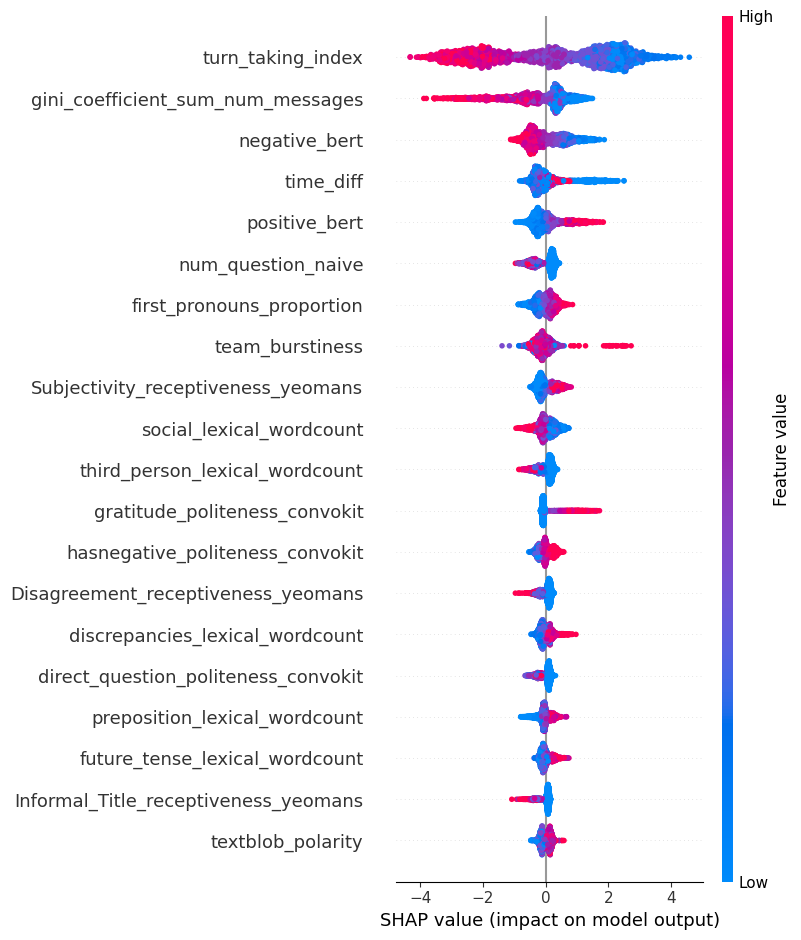

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.88 | 0.88
--------------------------
Precision | 0.88 | 0.88
--------------------------
Recall    | 0.87 | 0.88
--------------------------


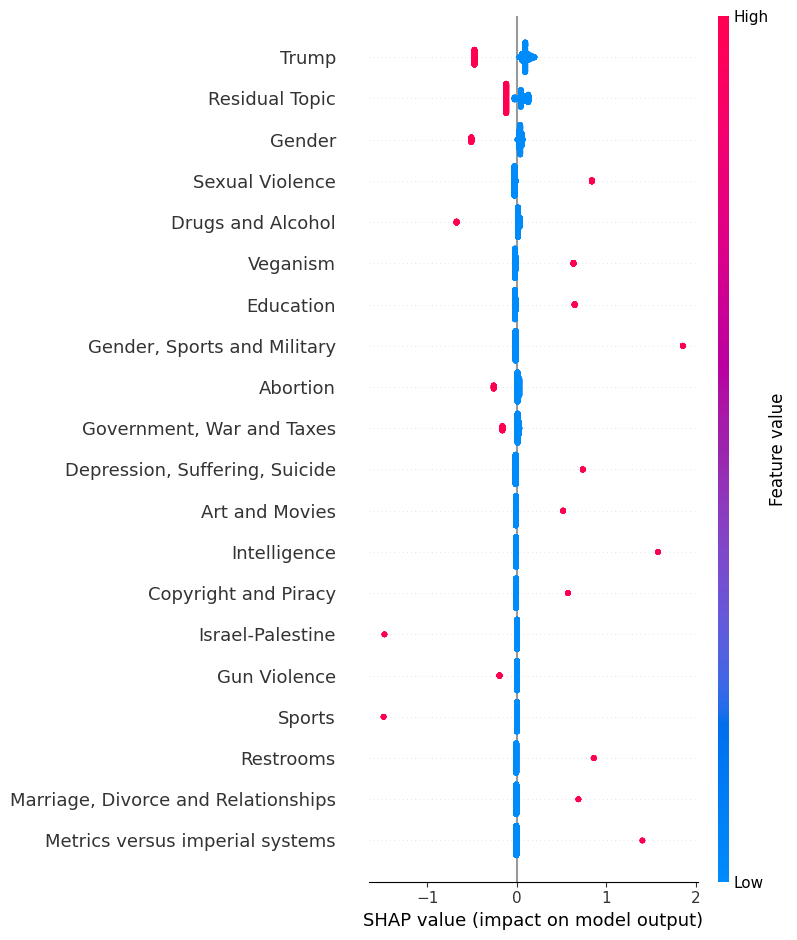

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.67 | 0.47
--------------------------
Precision | 0.56 | 0.68
--------------------------
Recall    | 0.83 | 0.36
--------------------------


Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.82 | 0.82
--------------------------
Precision | 0.82 | 0.82
--------------------------
Recall    | 0.81 | 0.83
--------------------------


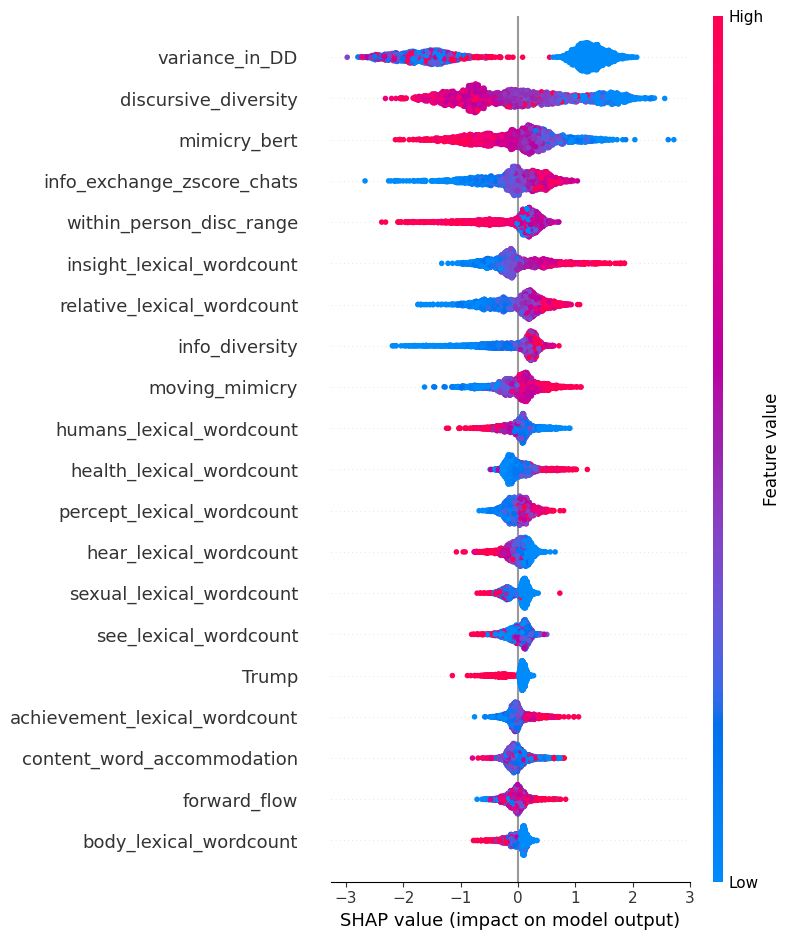

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.82 | 0.82
--------------------------
Precision | 0.82 | 0.82
--------------------------
Recall    | 0.81 | 0.83
--------------------------


Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.88 | 0.88
--------------------------
Precision | 0.88 | 0.88
--------------------------
Recall    | 0.87 | 0.89
--------------------------


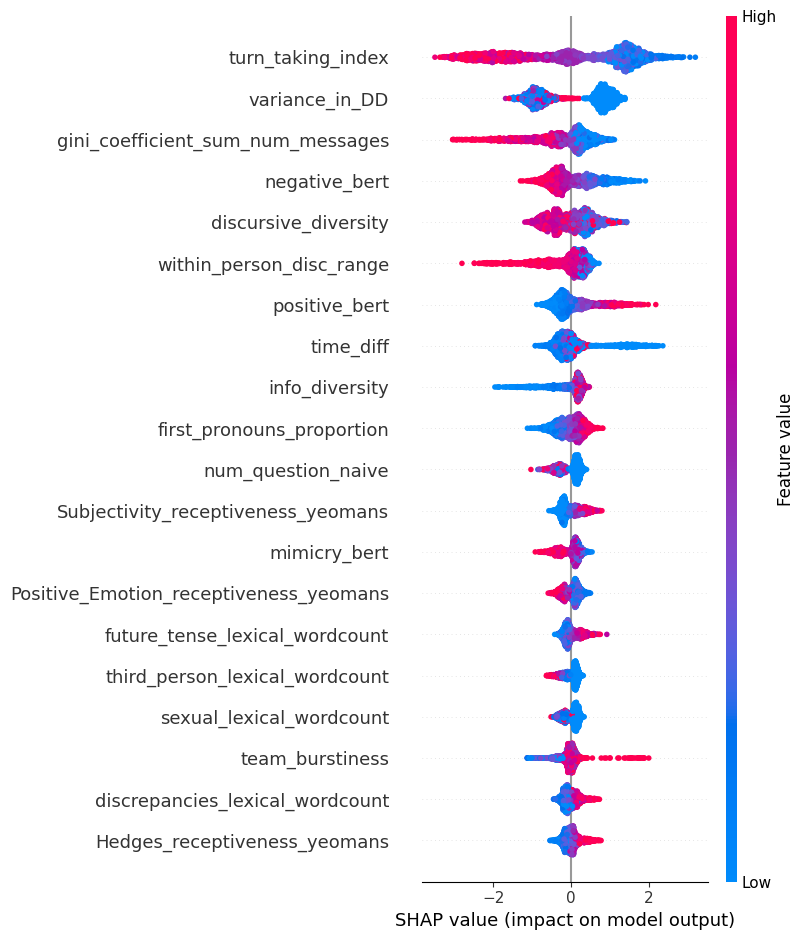

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.88 | 0.89
--------------------------
Precision | 0.89 | 0.88
--------------------------
Recall    | 0.87 | 0.89
--------------------------


In [ ]:
xgboost_classification_2(reddit_combined,'outcome',EXPRESSION_ONLY_1)
xgboost_classification_2(reddit_combined,'outcome',CONTENT_TOPICS_ONLY_2)
xgboost_classification_2(reddit_combined,'outcome',CONTENT_SEMANTIC_ONLY_3)
xgboost_classification_2(reddit_combined,'outcome',CONTENT_TOPICS_AND_SEMANTIC_4)
xgboost_classification_2(reddit_combined,'outcome',EXPRESSION_AND_SEMANTIC_SIMILARITY_5)
xgboost_classification_2(reddit_combined,'outcome',ALL_FEATURES_6)

### GPT generated data

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.99 | 0.99
--------------------------
Precision | 0.98 | 1.00
--------------------------
Recall    | 1.00 | 0.98
--------------------------


Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.89 | 0.89
--------------------------
Precision | 0.90 | 0.89
--------------------------
Recall    | 0.88 | 0.90
--------------------------


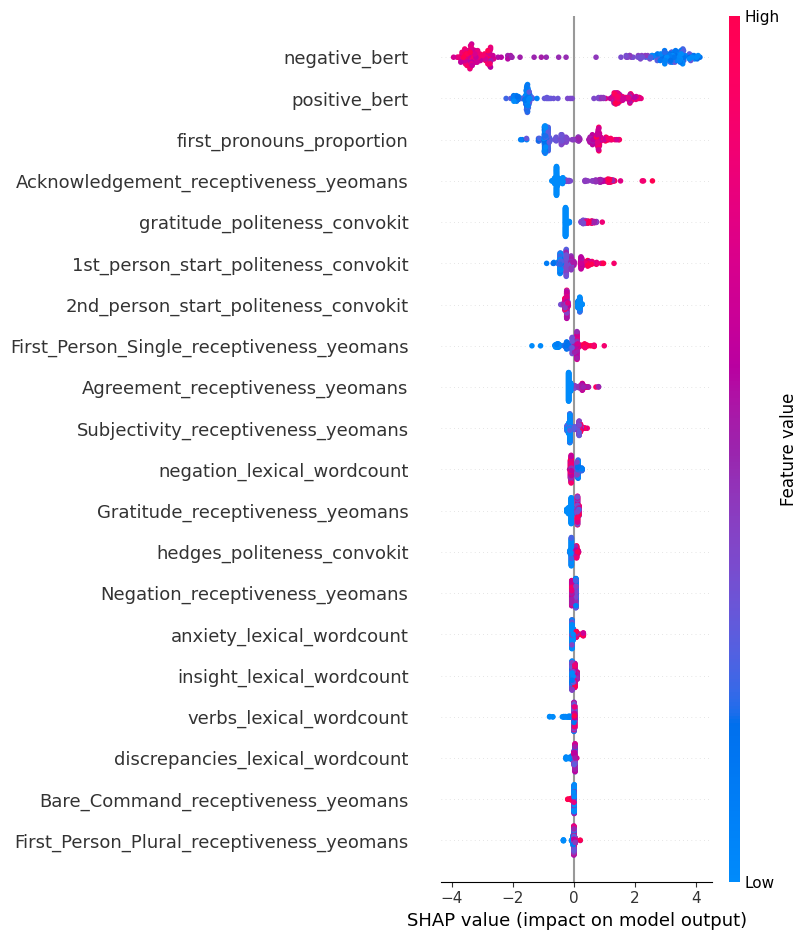

Metrics for predicting outcome using XGBoost

--------------------------
Metric    | Low  | High
--------------------------
F1        | 0.99 | 0.99
--------------------------
Precision | 0.98 | 1.00
--------------------------
Recall    | 1.00 | 0.98
--------------------------


In [ ]:
xgboost_classification_2(gpt_combined,'outcome',EXPRESSION_ONLY_1)
xgboost_classification_2(gpt_combined,'outcome',CONTENT_SEMANTIC_ONLY_3)
xgboost_classification_2(gpt_combined,'outcome',EXPRESSION_AND_SEMANTIC_SIMILARITY_5)